In [1]:
import pandas as pd
import numpy as np
import datetime
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler





Подошел к заданию следующим образом - нужно определить три аэропорта прилета с минимальной вероятностью задержки - то есть
в конкретную дату я знаю количество вылетов из аэропорта компанию перевозчика, номе рейса, дистанцию. Остальная информация в тестовой выборке
мне не известна

Загружаем данные

In [2]:
airports = pd.read_csv('airports.csv')
flights = pd.read_csv('flights.csv')

/var/folders/m9/x7jxk9jx2g9ch4ngnwz3n8wh0000gn/T/ipykernel_69051/1288301204.py:2: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flights = pd.read_csv('flights.csv')


Таблицы содержат следующую информацию

пропуски в данных


In [3]:
for col in flights.columns:
    pct_missing = np.mean(flights[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

YEAR - 0%
MONTH - 0%
DAY - 0%
DAY_OF_WEEK - 0%
AIRLINE - 0%
FLIGHT_NUMBER - 0%
TAIL_NUMBER - 0%
ORIGIN_AIRPORT - 0%
DESTINATION_AIRPORT - 0%
SCHEDULED_DEPARTURE - 0%
DEPARTURE_TIME - 1%
DEPARTURE_DELAY - 1%
TAXI_OUT - 2%
WHEELS_OFF - 2%
SCHEDULED_TIME - 0%
ELAPSED_TIME - 2%
AIR_TIME - 2%
DISTANCE - 0%
WHEELS_ON - 2%
TAXI_IN - 2%
SCHEDULED_ARRIVAL - 0%
ARRIVAL_TIME - 2%
ARRIVAL_DELAY - 2%
DIVERTED - 0%
CANCELLED - 0%
CANCELLATION_REASON - 98%
AIR_SYSTEM_DELAY - 82%
SECURITY_DELAY - 82%
AIRLINE_DELAY - 82%
LATE_AIRCRAFT_DELAY - 82%
WEATHER_DELAY - 82%


In [4]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

объединяю данные, удаляется информация о части аэропортовс кодом в виде цифр, дплее по координатам строю несколько графиков

In [5]:
flights = flights.merge(airports, how='right', left_on='ORIGIN_AIRPORT', right_on='IATA_CODE')

In [6]:
flights['HOUR'] = flights['SCHEDULED_DEPARTURE']//100
flights['MINUTE'] = flights['SCHEDULED_DEPARTURE']%100
flights['DATE'] = pd.to_datetime(flights[['YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE']])
flights['DATE_DAY'] = pd.to_datetime(flights[['YEAR', 'MONTH', 'DAY']])



In [7]:
flights.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'IATA_CODE', 'AIRPORT', 'CITY',
       'STATE', 'COUNTRY', 'LATITUDE', 'LONGITUDE', 'HOUR', 'MINUTE', 'DATE',
       'DATE_DAY'],
      dtype='object')

Проанализируем аэропорты по количеству вылетов

На карте

In [8]:
a = flights.groupby('ORIGIN_AIRPORT')['DATE'].count().sort_values(ascending=False).reset_index()
b = airports.merge(a, how='right', left_on='IATA_CODE', right_on='ORIGIN_AIRPORT')

In [9]:
fig = px.scatter_mapbox(b,
                        lon = b.LONGITUDE,
                        lat = b.LATITUDE,
                        zoom = 3,
                        color = b.DATE,
                        size = b.DATE,
                        width = 800,
                        height = 600,
)
fig.update_layout(mapbox_style='open-street-map')
fig.show()

Теперь в разрезе дат
наблюдается цикличность, можно сделать вывод, что от дня недели зависит количество вылетов,
данные за октябрь отсутствую

<AxesSubplot:xlabel='DATE'>

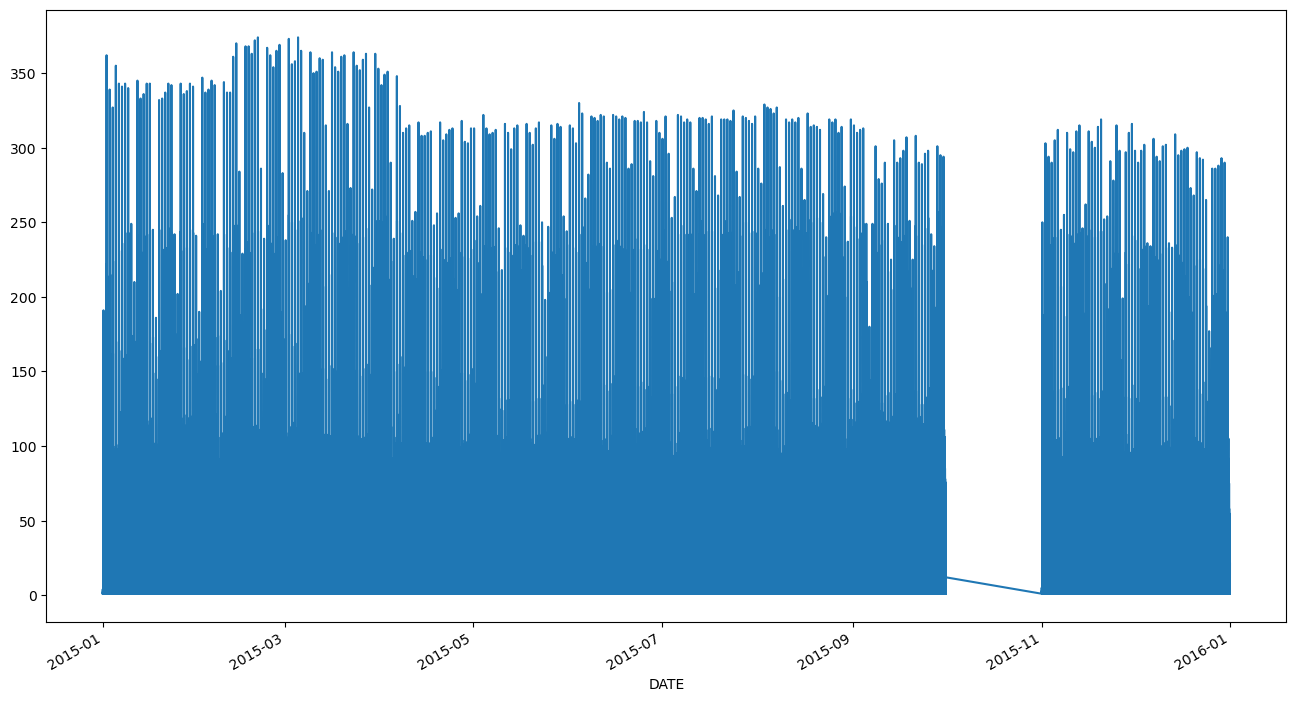

In [10]:
flights.groupby('DATE')['DATE'].count().plot(figsize=[16, 9])

<AxesSubplot:xlabel='DATE_DAY'>

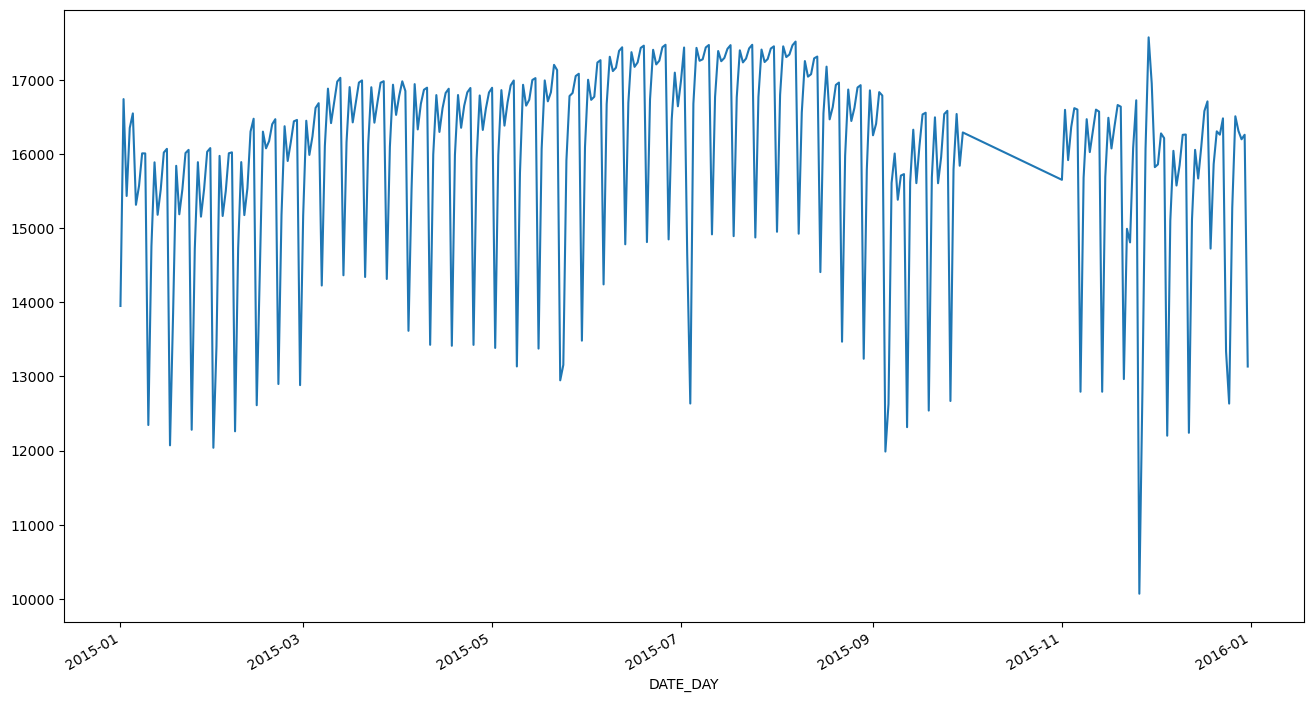

In [11]:
flights.groupby('DATE_DAY')['DATE_DAY'].count().plot(figsize=[16, 9])

Далее рассматриваю период январь - сентябрь

In [12]:
flights = flights.loc[flights['DATE'].between('2015-01-01', '2015-09-30')]

Тоже с заданными датами

<AxesSubplot:xlabel='DATE'>

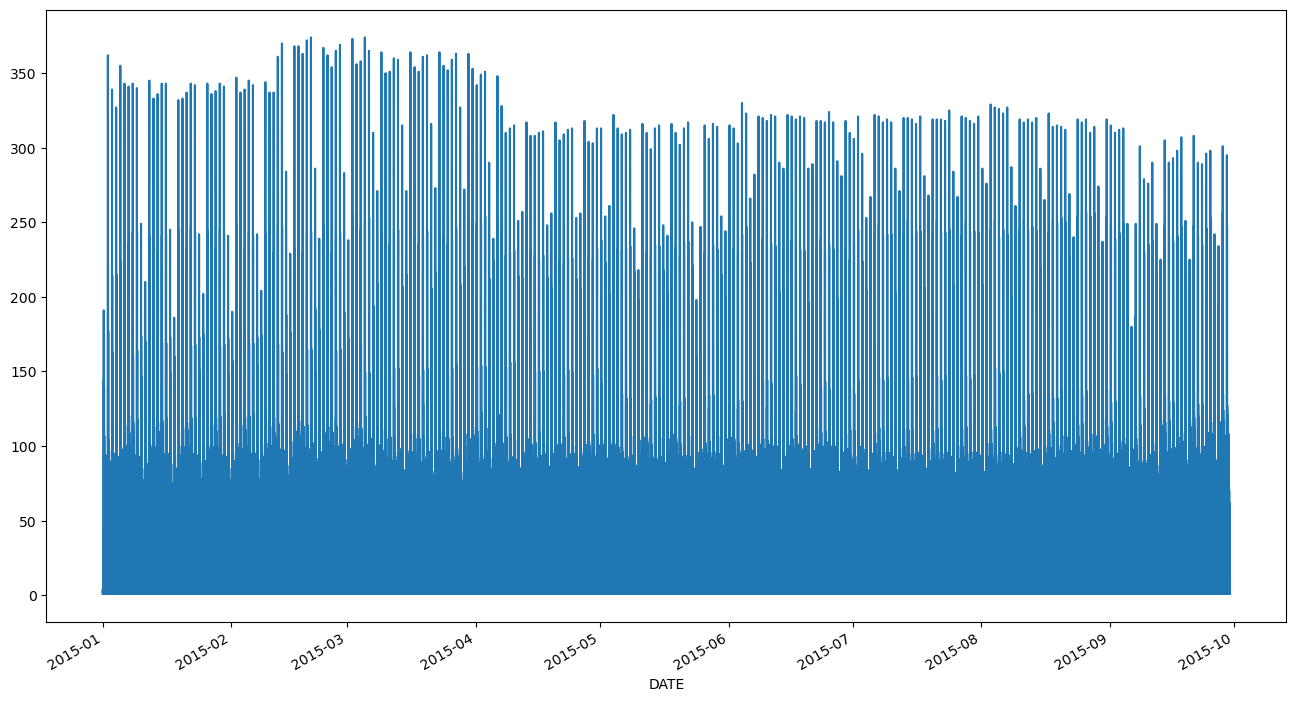

In [13]:
flights.groupby('DATE')['DATE'].count().plot(figsize=[16, 9])

<AxesSubplot:xlabel='DATE_DAY'>

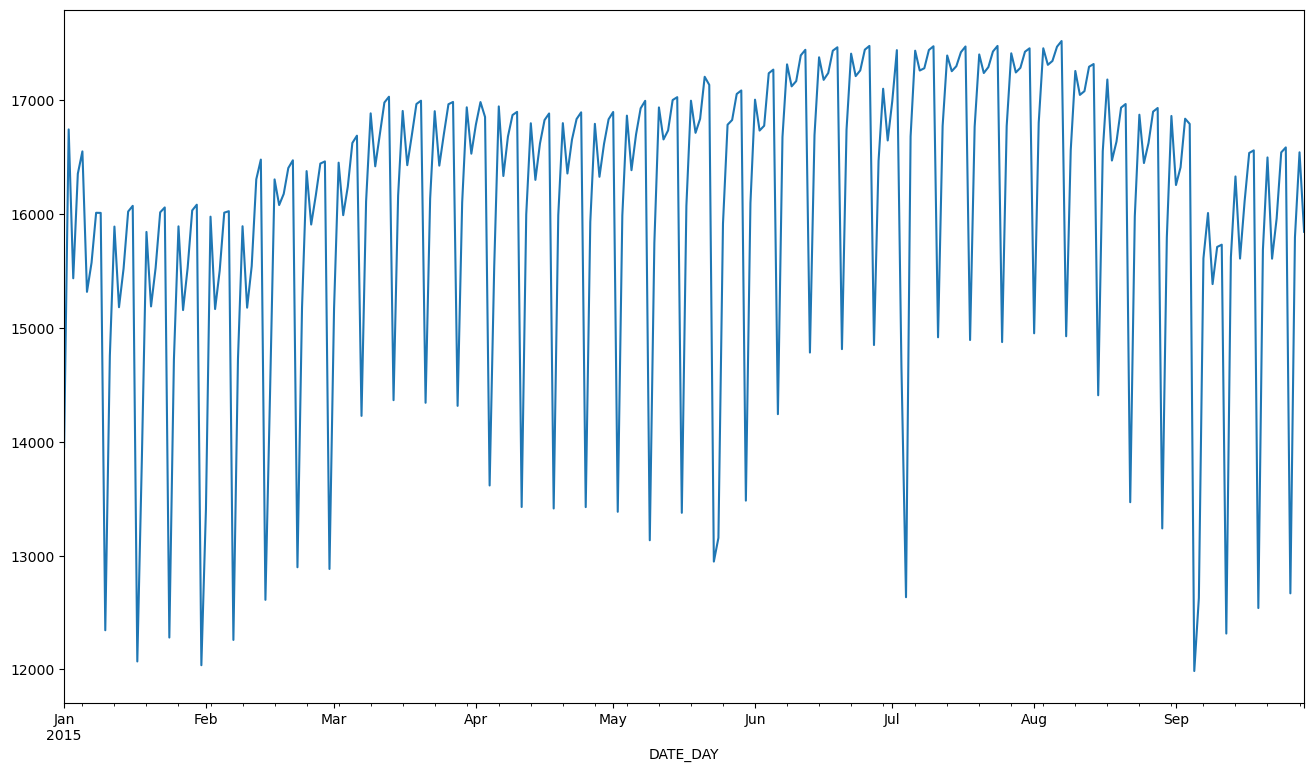

In [14]:
flights.groupby('DATE_DAY')['DATE_DAY'].count().plot(figsize=[16, 9])

Посмотрим на количество вылетов в разные дни недели - в выходные значительно снижается количество вылетов

<AxesSubplot:xlabel='DAY_OF_WEEK'>

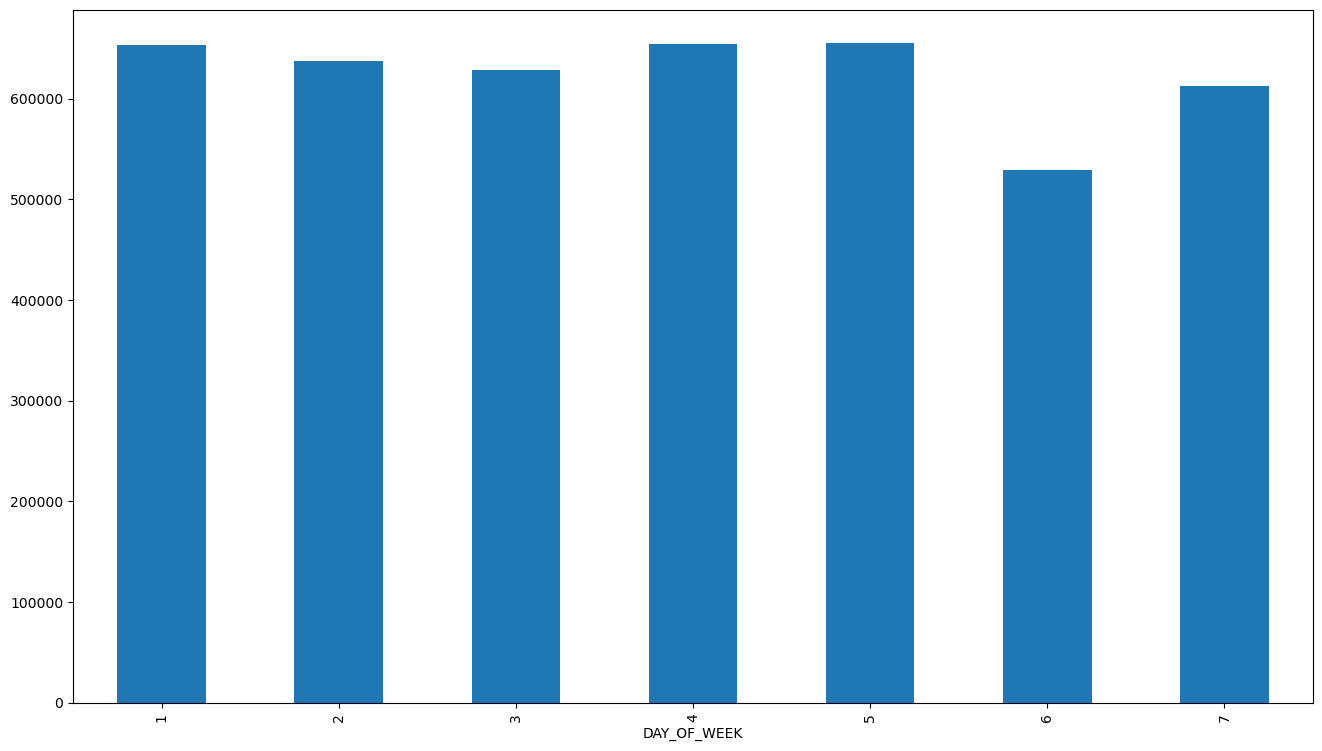

In [15]:
flights.groupby('DAY_OF_WEEK')['DATE_DAY'].count().plot.bar(figsize=[16, 9])

<AxesSubplot:xlabel='DAY_OF_WEEK'>

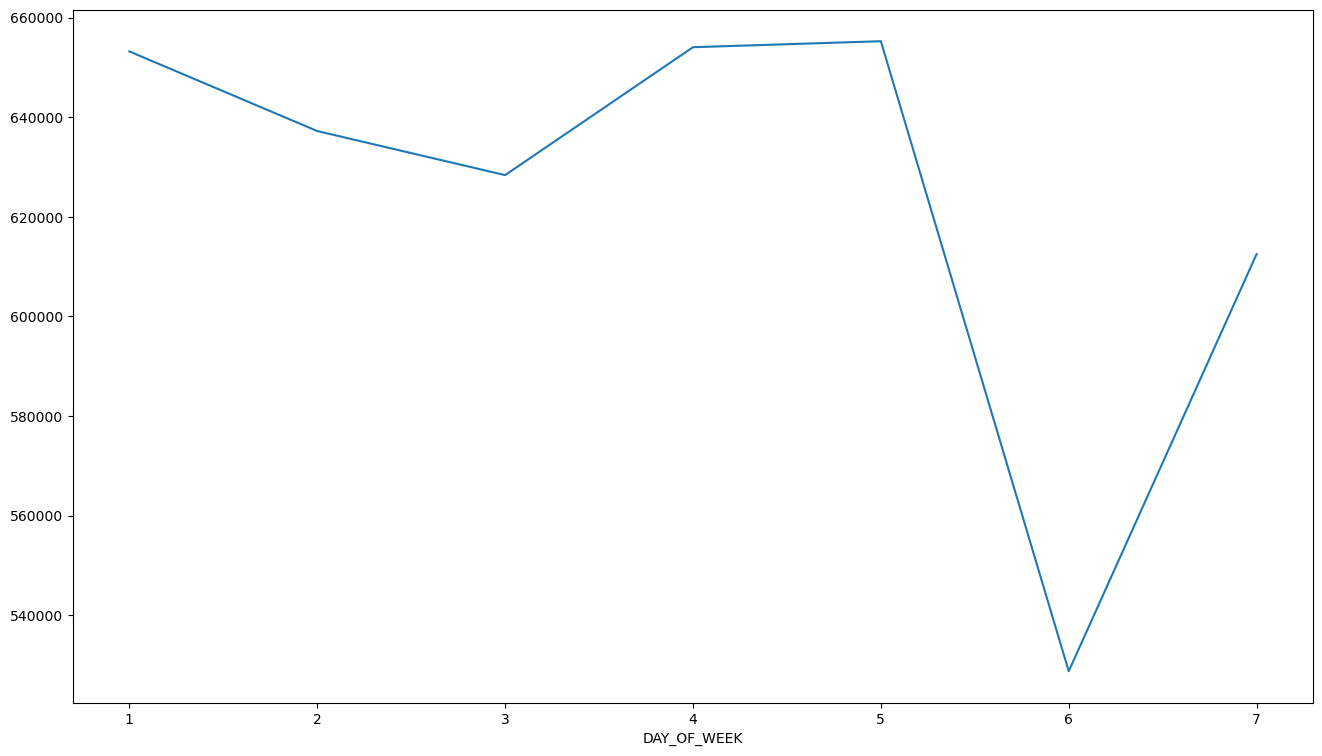

In [16]:
flights.groupby('DAY_OF_WEEK')['DATE'].count().plot(figsize=[16, 9])

Посмотрим на количество задержек
создадим колонку, которая будет отражать инфорацию о вылете самолета в срок. 1 - вылетел в срок, 0 - не вылетел в срок

In [17]:
flights['DEPARTURE_DELAY'].fillna(1, inplace=True)
flights['PROBABILITY'] = np.where(flights['DEPARTURE_DELAY']>0, 0, 1)

Посмотрим на распределение общего количества задержек по дням - прослеживается та же цикличность

<AxesSubplot:xlabel='DATE'>

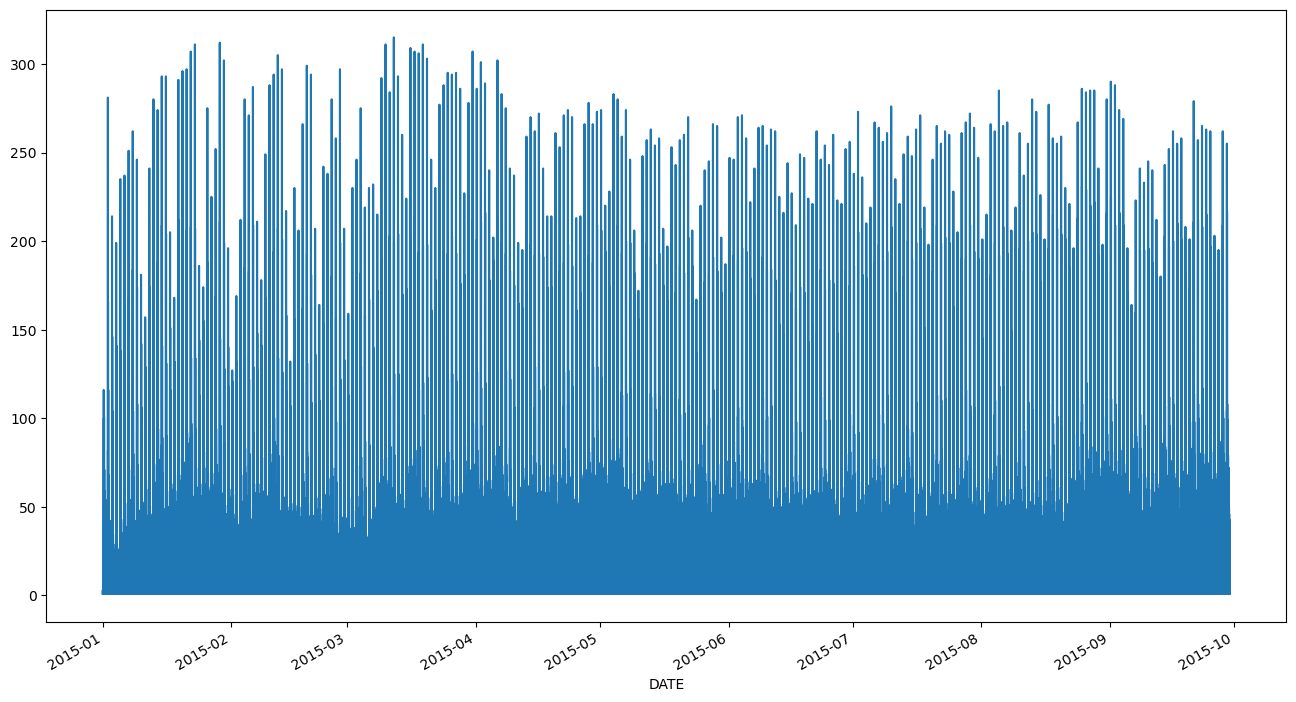

In [18]:
flights.query('PROBABILITY > 0').groupby('DATE')['PROBABILITY'].count().plot(figsize=[16, 9])

<AxesSubplot:xlabel='DATE_DAY'>

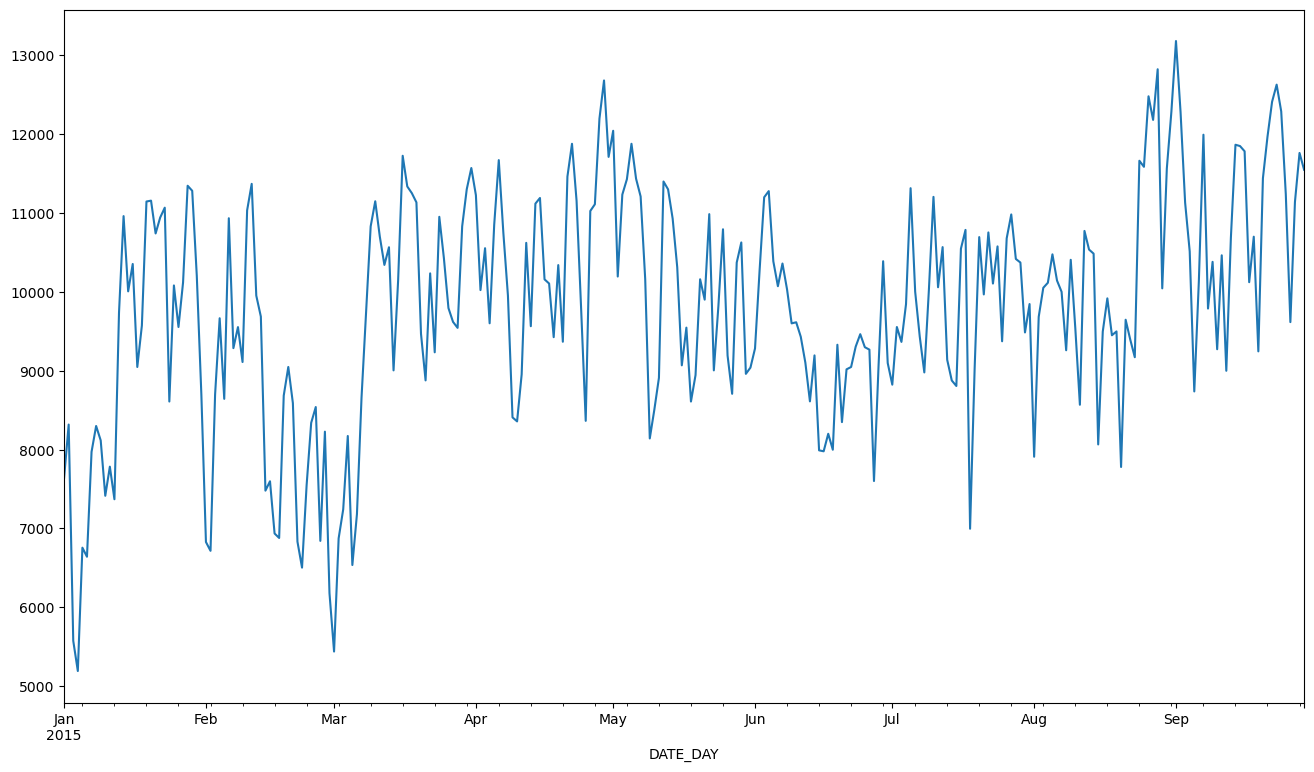

In [19]:
flights.query('PROBABILITY > 0').groupby('DATE_DAY')['PROBABILITY'].count().plot(figsize=[16, 9])

Тоже на карте для разных аэропортов

In [20]:
a = flights.query('PROBABILITY == 0').groupby('ORIGIN_AIRPORT')['PROBABILITY'].count().sort_values(ascending=False).reset_index()
b = airports.merge(a, how='right', left_on='IATA_CODE', right_on='ORIGIN_AIRPORT')

In [21]:
fig = px.scatter_mapbox(b,
                        lon = b.LONGITUDE,
                        lat = b.LATITUDE,
                        zoom = 3,
                        color = b.PROBABILITY,
                        size = b.PROBABILITY,
                        width = 800,
                        height = 600,
)
fig.update_layout(mapbox_style='open-street-map')
fig.show()

Теперь посмотрим на среденее значение вероятности вылететь без задержки в разрезе дней

<AxesSubplot:xlabel='DAY_OF_WEEK'>

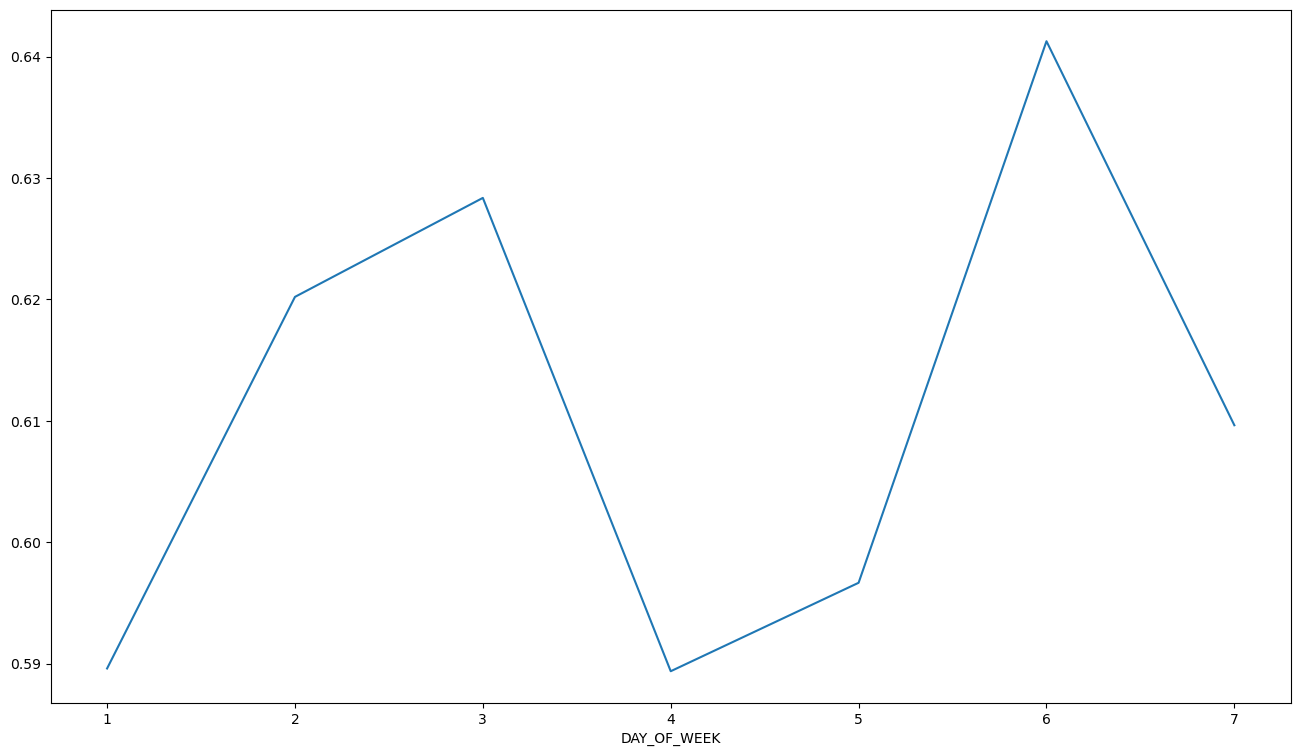

In [22]:
flights.groupby('DAY_OF_WEEK')['PROBABILITY'].mean().plot(figsize=[16, 9])

Совместим графики - прослеживается зависимость - чем больше количество вылетов, тем ниже вероятность улететь вовремя. Так же присутствуют пики по дням недели. И в целом, в 
начале пиков аэропорты справляюся, но при накоплении рейсов происходит резкое падение вылетов в срок.

<AxesSubplot:xlabel='DATE_DAY'>

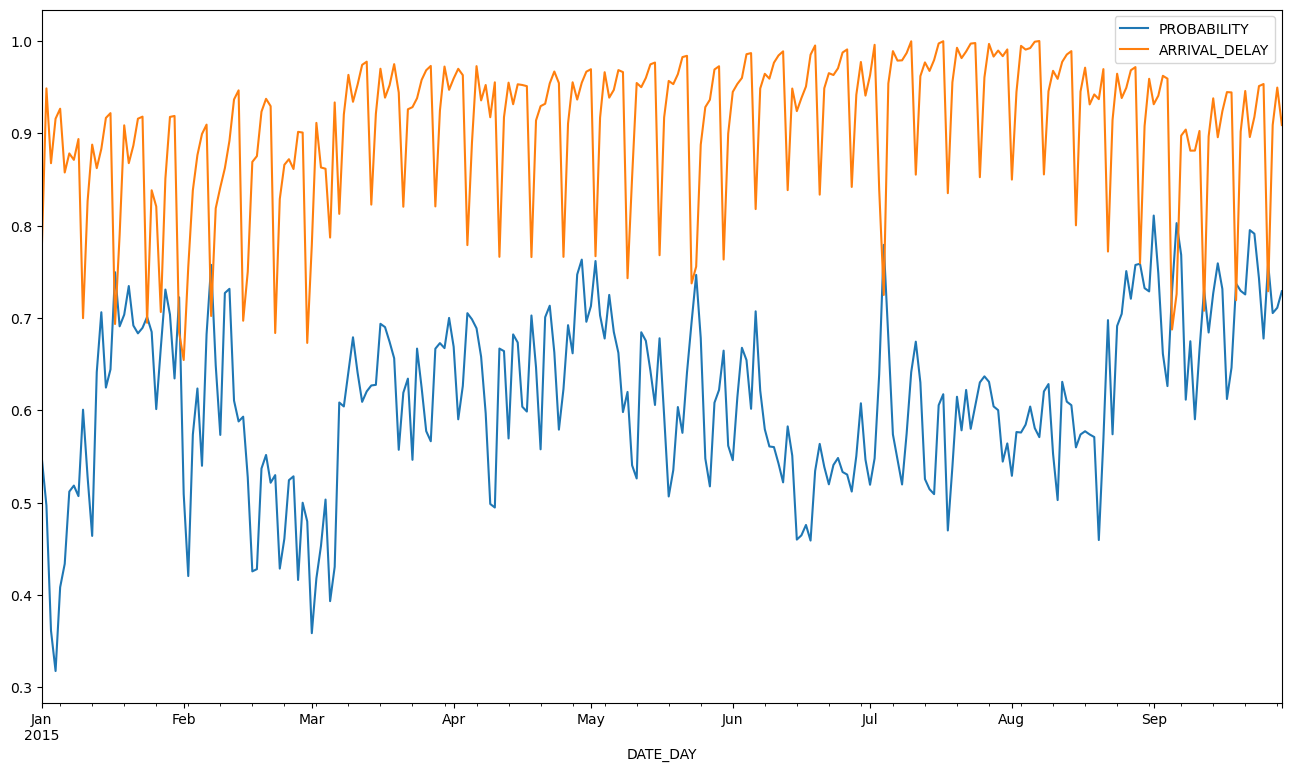

In [23]:
a = flights.groupby('DATE_DAY')['ARRIVAL_DELAY'].count().reset_index()
a['ARRIVAL_DELAY'] = a['ARRIVAL_DELAY']/a['ARRIVAL_DELAY'].max()
b = flights.groupby('DATE_DAY')['PROBABILITY'].mean().reset_index()
df = b.merge(a, how='right', left_on='DATE_DAY', right_on='DATE_DAY').set_index('DATE_DAY')
df.plot(figsize=[16, 9])

Тоже сделаем для дней недели

<AxesSubplot:xlabel='DAY_OF_WEEK'>

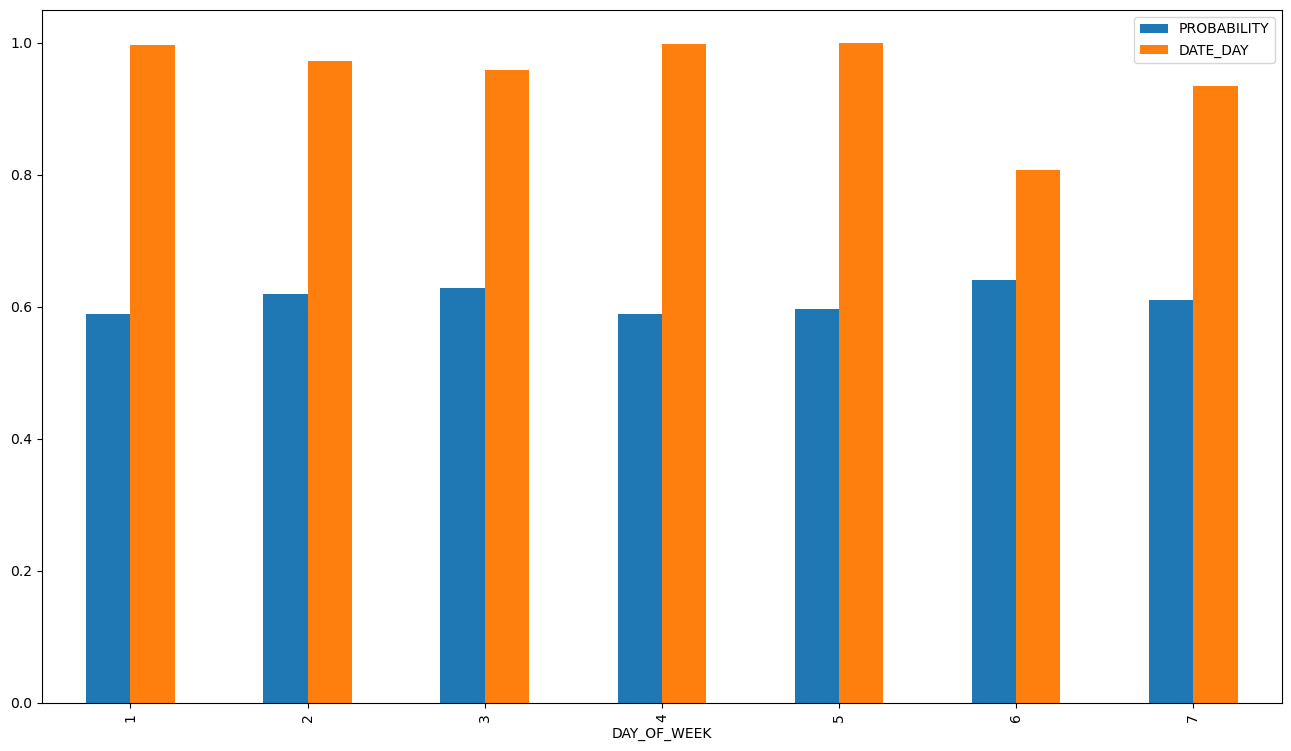

In [24]:
a = flights.groupby('DAY_OF_WEEK')['DATE_DAY'].count().reset_index()
a['DATE_DAY'] = a['DATE_DAY']/a['DATE_DAY'].max()
b = flights.groupby('DAY_OF_WEEK')['PROBABILITY'].mean().reset_index()
df = b.merge(a, how='right', left_on='DAY_OF_WEEK', right_on='DAY_OF_WEEK').set_index('DAY_OF_WEEK')
df.plot.bar(figsize=[16, 9])

<AxesSubplot:xlabel='DAY_OF_WEEK'>

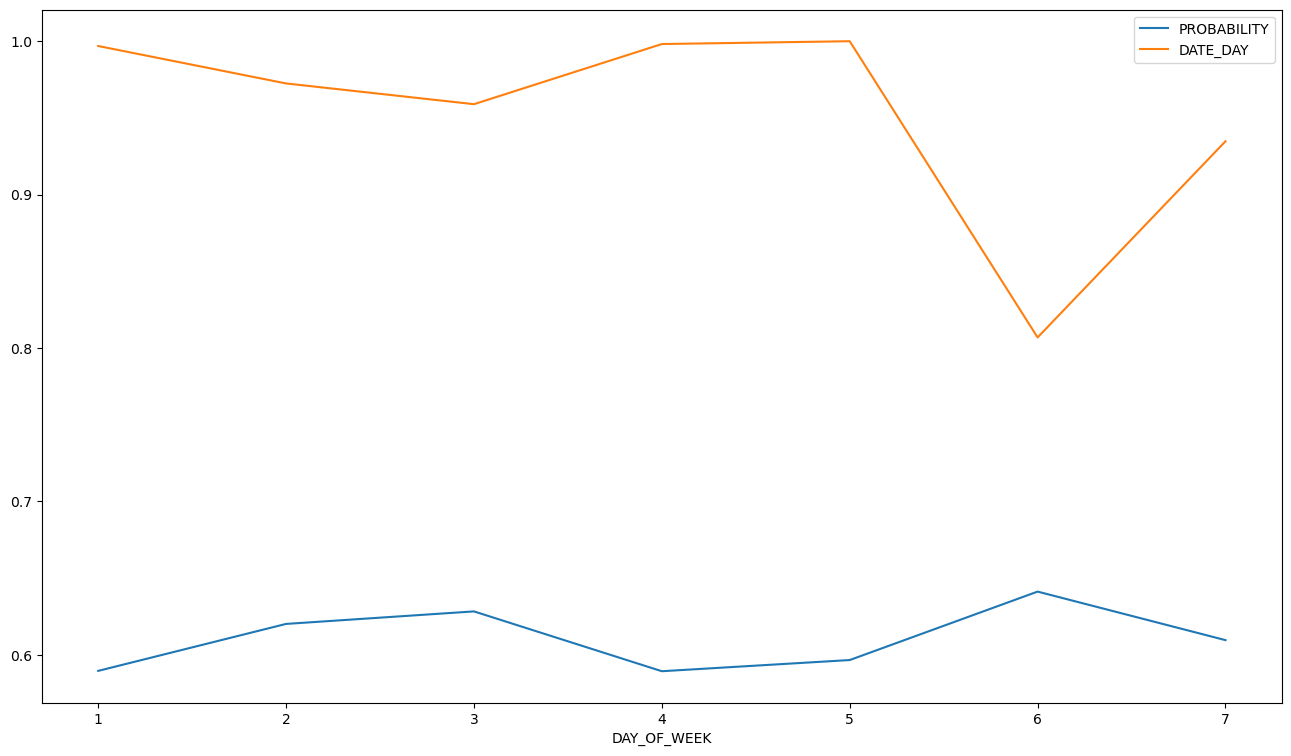

In [25]:
a = flights.groupby('DAY_OF_WEEK')['DATE_DAY'].count().reset_index()
a['DATE_DAY'] = a['DATE_DAY']/a['DATE_DAY'].max()
b = flights.groupby('DAY_OF_WEEK')['PROBABILITY'].mean().reset_index()
df = b.merge(a, how='right', left_on='DAY_OF_WEEK', right_on='DAY_OF_WEEK').set_index('DAY_OF_WEEK')
df.plot(figsize=[16, 9])

Теперь построим диаграмму, характеризующую вероятность улететь вовремя для авиаперевозчиков

<AxesSubplot:xlabel='AIRLINE'>

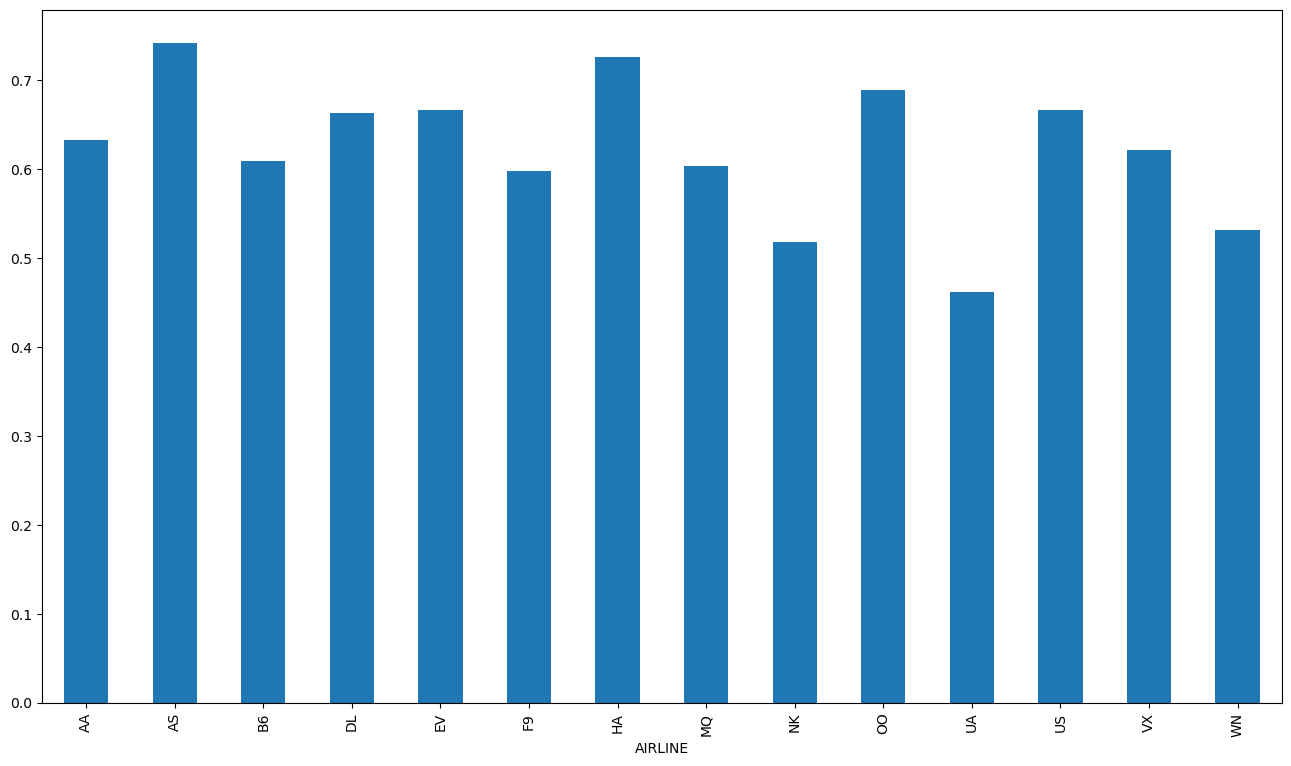

In [26]:
a = flights.groupby('AIRLINE')['PROBABILITY'].mean()
a.plot.bar(figsize=[16, 9])

Количесто перелетов для авиаперевозчиков

<AxesSubplot:xlabel='AIRLINE'>

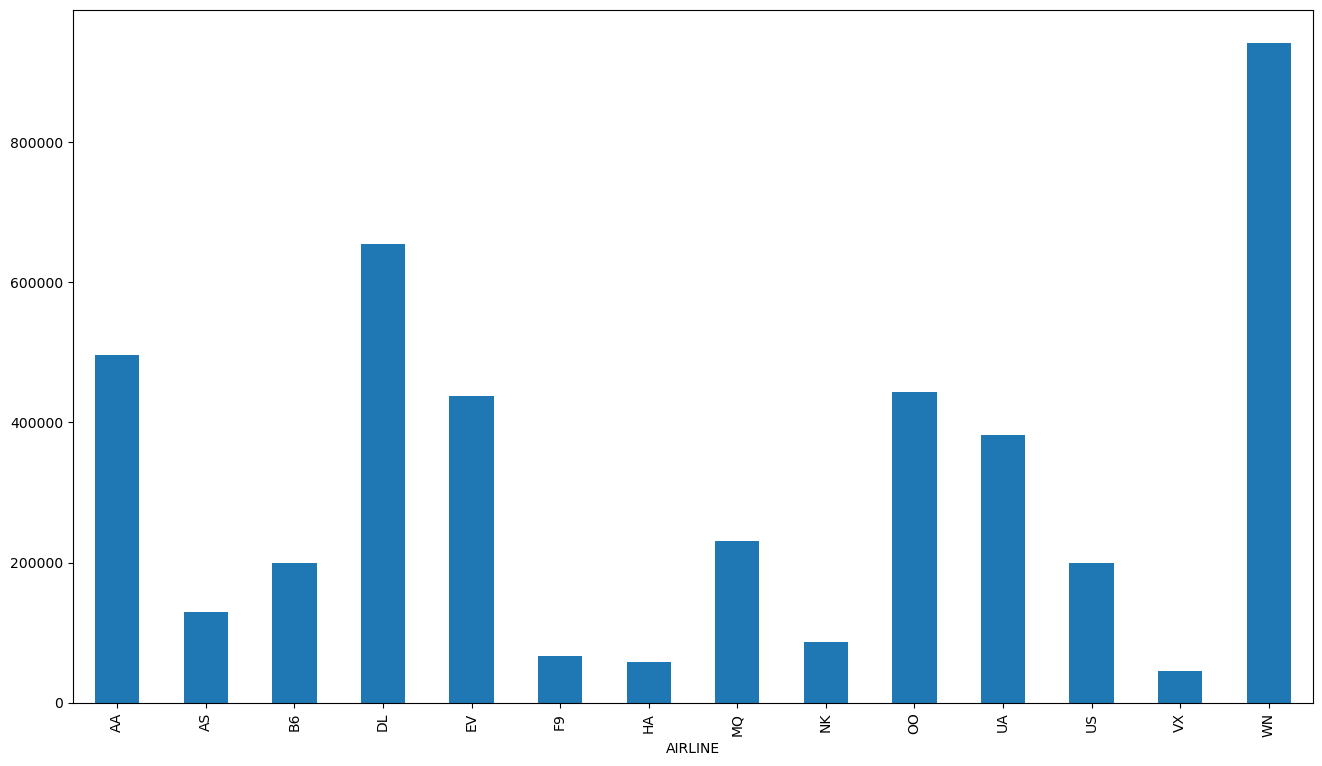

In [27]:
a = flights.groupby('AIRLINE')['DATE'].count()
a.plot.bar(figsize=[16, 9])

<AxesSubplot:xlabel='CANCELLATION_REASON'>

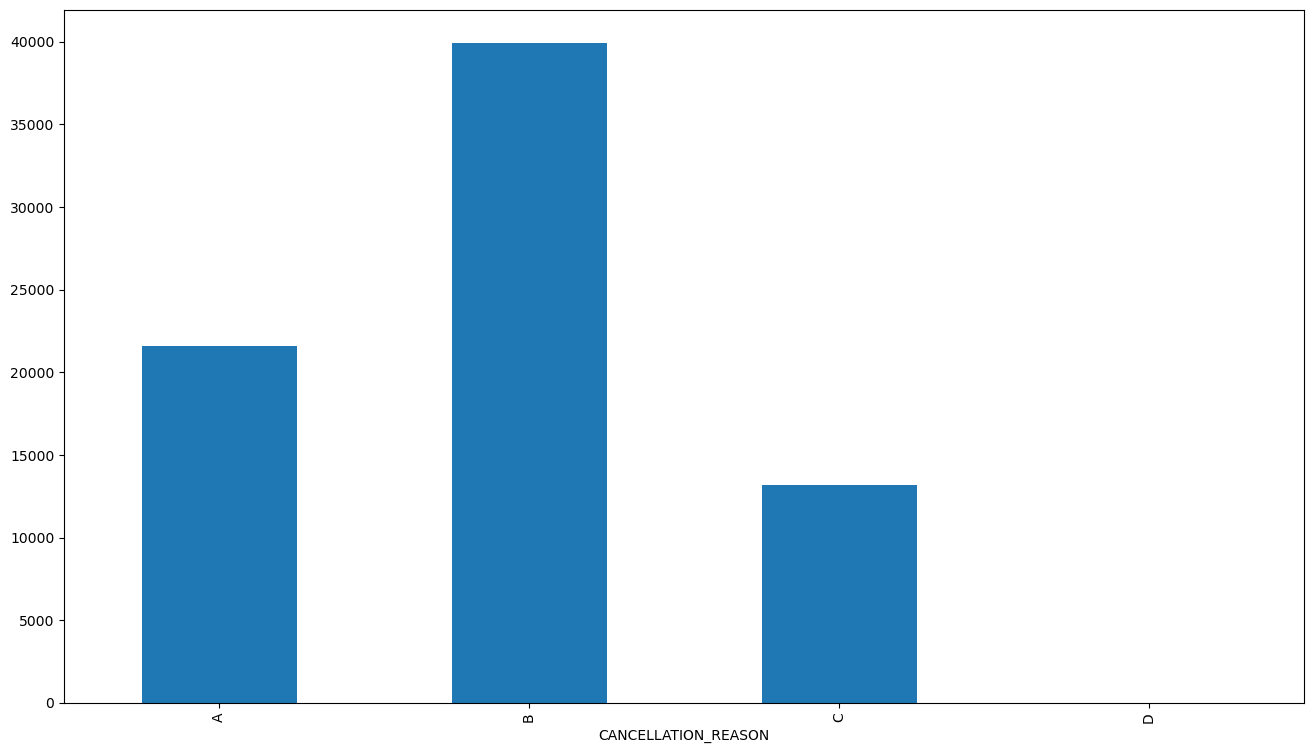

In [28]:
flights.groupby('CANCELLATION_REASON')['DATE_DAY'].count().plot.bar(figsize=[16, 9])

<AxesSubplot:xlabel='DATE_DAY'>

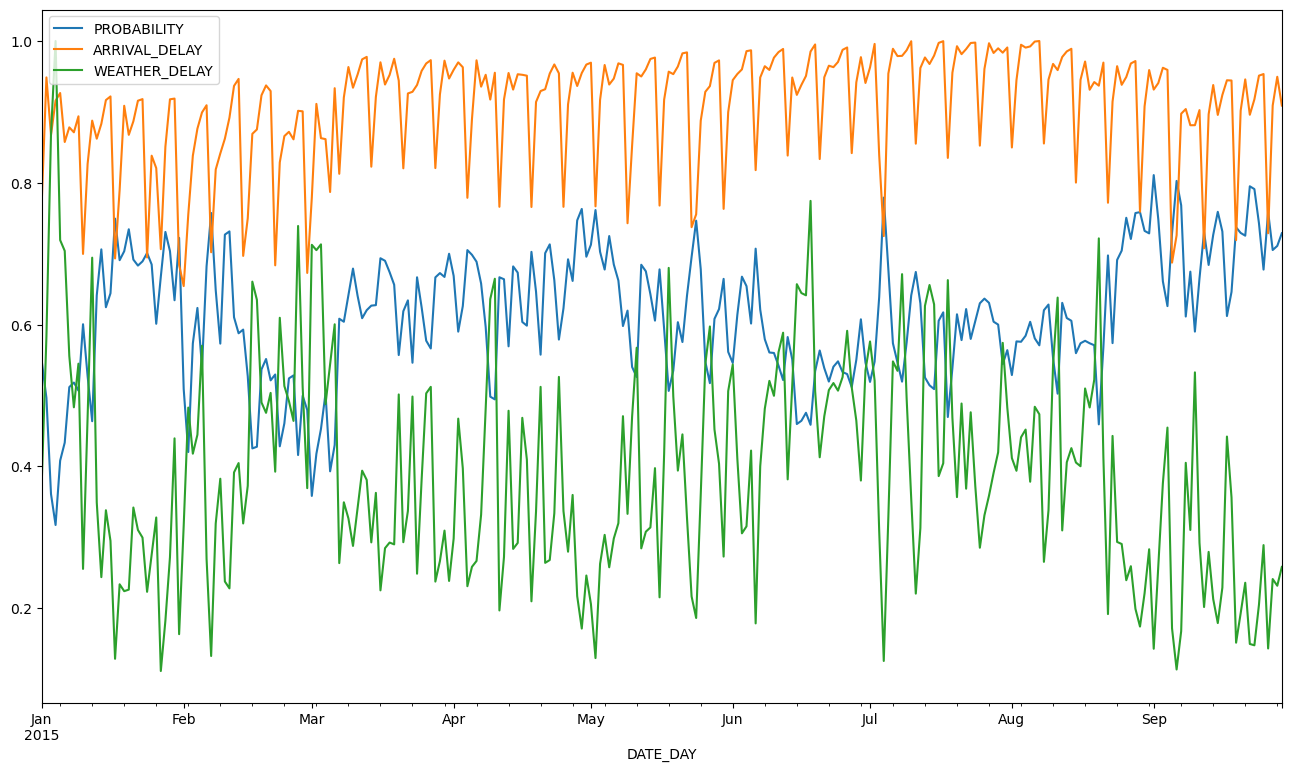

In [29]:
a = flights.groupby('DATE_DAY')['ARRIVAL_DELAY'].count().reset_index()
a['ARRIVAL_DELAY'] = a['ARRIVAL_DELAY']/a['ARRIVAL_DELAY'].max()
b = flights.groupby('DATE_DAY')['PROBABILITY'].mean().reset_index()
df = b.merge(a, how='right', left_on='DATE_DAY', right_on='DATE_DAY').set_index('DATE_DAY')
b = flights.groupby('DATE_DAY')['WEATHER_DELAY'].count().reset_index()
b['WEATHER_DELAY'] = b['WEATHER_DELAY']/b['WEATHER_DELAY'].max()
df = df.merge(b, how='right', left_on='DATE_DAY', right_on='DATE_DAY').set_index('DATE_DAY')

df.plot(figsize=[16, 9])


In [30]:
flights['WEATHER_DELAY'].fillna(0, inplace=True)
flights.query("WEATHER_DELAY == 0", inplace=True)

<AxesSubplot:xlabel='DATE_DAY'>

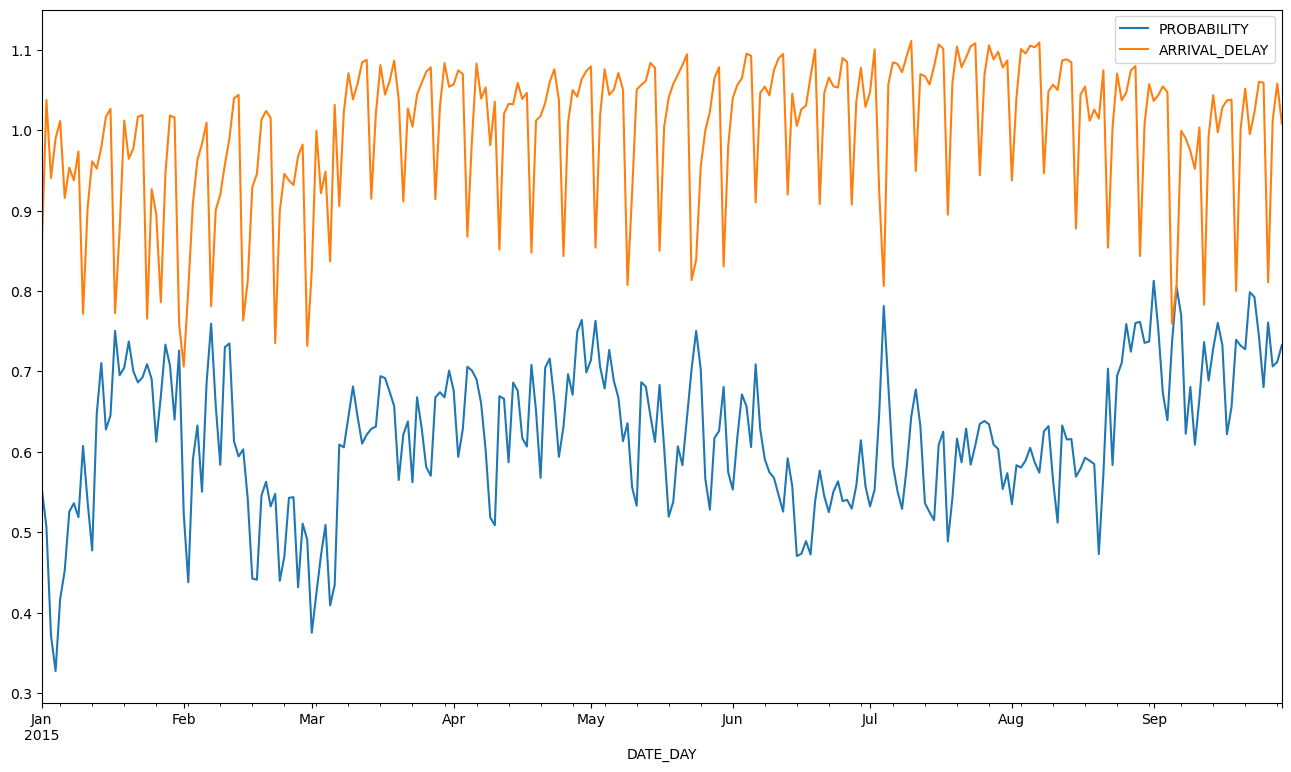

In [31]:
a = flights.groupby('DATE_DAY')['ARRIVAL_DELAY'].count().reset_index()
a['ARRIVAL_DELAY'] = a['ARRIVAL_DELAY']/a['ARRIVAL_DELAY'].mean()
b = flights.groupby('DATE_DAY')['PROBABILITY'].mean().reset_index()
df = b.merge(a, how='right', left_on='DATE_DAY', right_on='DATE_DAY').set_index('DATE_DAY')
df.plot(figsize=[16, 9])

<AxesSubplot:xlabel='DAY_OF_WEEK'>

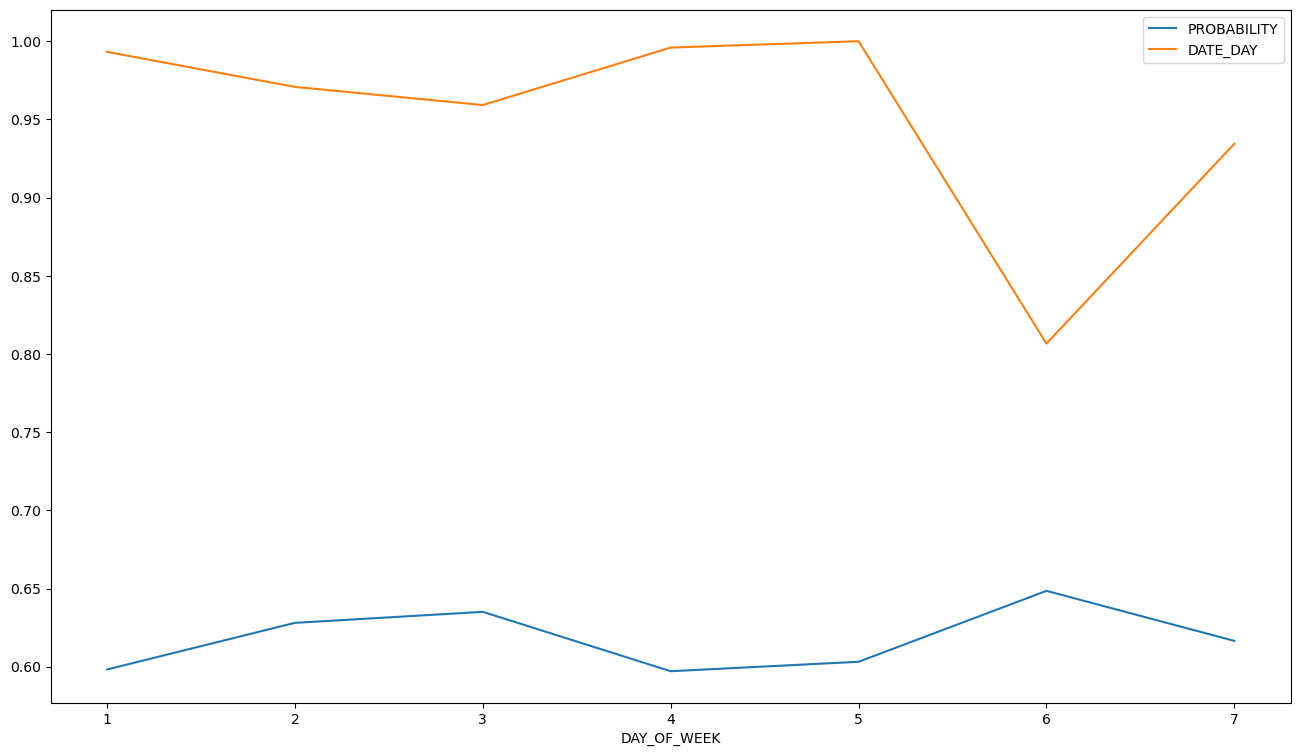

In [32]:
a = flights.groupby('DAY_OF_WEEK')['DATE_DAY'].count().reset_index()
a['DATE_DAY'] = a['DATE_DAY']/a['DATE_DAY'].max()
b = flights.groupby('DAY_OF_WEEK')['PROBABILITY'].mean().reset_index()
df = b.merge(a, how='right', left_on='DAY_OF_WEEK', right_on='DAY_OF_WEEK').set_index('DAY_OF_WEEK')
df.plot(figsize=[16, 9])

Посмотрим, как распределяется время задержки по отношению к общему количеству рейсов для аэропортов. Здесь я хотел показать, что погода одинаково влияет на возможность вовремя вылететь.

In [33]:
a = flights.groupby('ORIGIN_AIRPORT')['WEATHER_DELAY'].sum().sort_values(ascending=False).reset_index()
a1 = flights.groupby('ORIGIN_AIRPORT')['DATE'].count().sort_values(ascending=False).reset_index()
a['WEATHER_DELAY'] = a['WEATHER_DELAY']/a1['DATE']

b = airports.merge(a, how='right', left_on='IATA_CODE', right_on='ORIGIN_AIRPORT')

In [34]:
fig = px.scatter_mapbox(b,
                        lon = b.LONGITUDE,
                        lat = b.LATITUDE,
                        zoom = 3,
                        color = b.WEATHER_DELAY,
                        size = b.WEATHER_DELAY,
                        width = 800,
                        height = 600,
)
fig.update_layout(mapbox_style='open-street-map')
fig.show()

In [35]:
c_time = flights.groupby('DATE').count().reset_index()
c_time['C_TIME'] = c_time['MONTH']
c_time = c_time[['DATE', 'C_TIME']]
flights = flights.merge(c_time, how='left', left_on='DATE', right_on='DATE')